In [0]:
!pip install mglearn

    100% |████████████████████████████████| 542kB 4.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/74/cf/8d/04f4932d15854a36726c6210763c7127e62de28f5c8ddfcf3b
Successfully built mglearn


In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

In [0]:
iris = load_iris()
logreg = LogisticRegression()

In [0]:
# cross validation takes 3 arguments: model, data, target
# by default it does 3 cvs
scores = cross_val_score(logreg, iris.data, iris.target)
print(f'cross validation scores: {scores}')

cross validation scores: [0.96078431 0.92156863 0.95833333]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWar

In [0]:
scores2 = cross_val_score(logreg, iris.data, iris.target, cv=5)
print(f'cross validation scores: {scores2}')

cross validation scores: [1.         0.96666667 0.93333333 0.9        1.        ]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed

In [0]:
# we expect the model to be about 96% accurate
# 100% accurate twice - the model is very dependant on particular folds 
# or could be because it's a small dataset
scores.mean(), scores2.mean()

(0.9468954248366014, 0.9600000000000002)

## Diagrams

In [0]:
from sklearn.model_selection import GridSearchCV
import mglearn

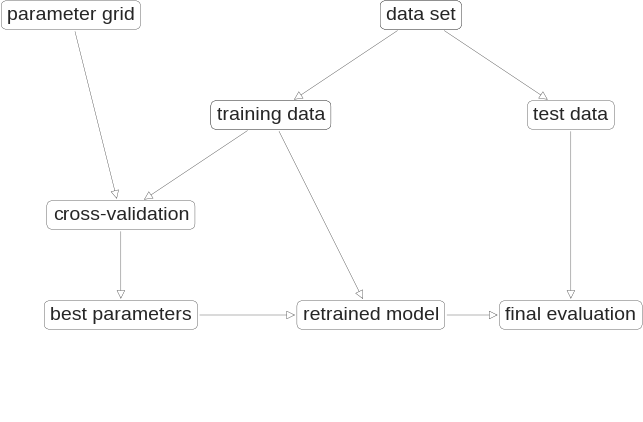

In [0]:
# Overview of the Process of Parameter Selection and Model Evaluation with GridSearchCV
mglearn.plots.plot_grid_search_overview()

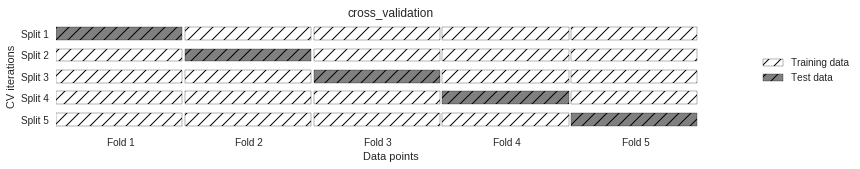

In [0]:
# 5 fold cross validation image
mglearn.plots.plot_cross_validation()

In [0]:
print(iris.target)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


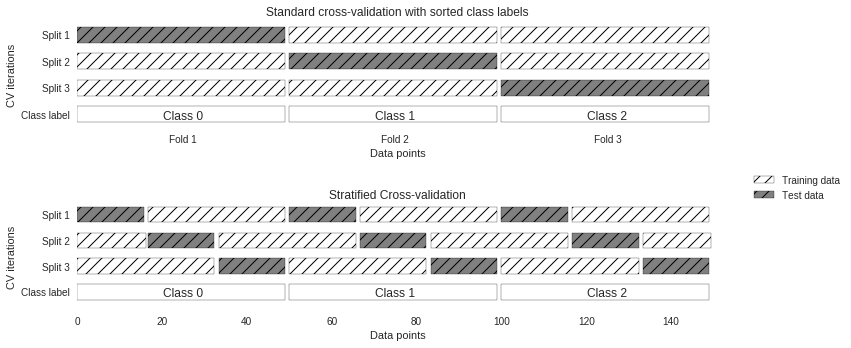

In [0]:
# stratification used when target is in order (ex: 000,111, 222,...)
# a good idea for iris dataset (see above target in order)
# using k-fold you get 0% accuracy

# Comparison of Standard Cross Validation & Stratified Cross Validation when the Data is Ordered by Class Label
mglearn.plots.plot_stratified_cross_validation()

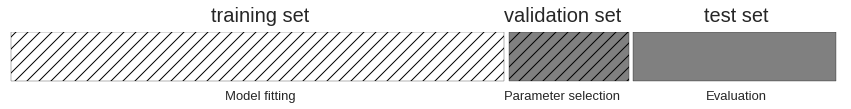

In [0]:
# Threefold splitting into Training, Validation, and Test Data
mglearn.plots.plot_threefold_split()

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


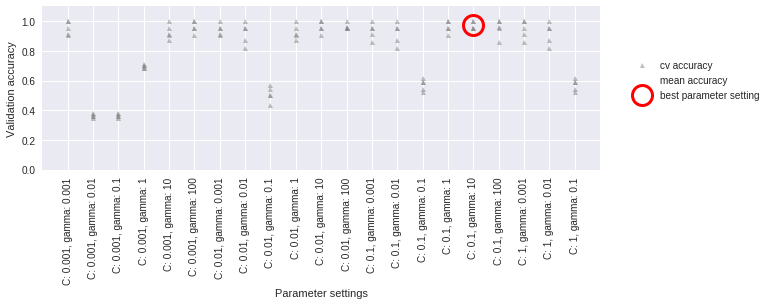

In [0]:
mglearn.plots.plot_cross_val_selection()

## GridSearch with Cross Validation

In [0]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]
}

In [0]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [0]:
# inside GridSearch = model, param_grid (dict), folds(cv)
# GridSearchCV for when you want to find best parameters but also wanting to do k-folds
grid_search = GridSearchCV(SVC(), param_grid, cv=5)

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
grid_search.fit(X_train, y_train)

grid_search.score(X_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.9736842105263158

In [0]:
# Note: the important thing here we did not use the test set to use paramenters
# the parameters found are store in the best_params attribute

# best parameters (see image above with red circle)
grid_search.best_params_

{'C': 100, 'gamma': 0.01}

In [0]:
# The best cross validation accuracy (the mean accuracy over the diff splits) is stored in best_score_
# be careful not to confuse best score with the score method - which employs a model on whole training test
# the best_score_ attribute stores the mean cross validation accuracy with cross validation performed on the training set
grid_search.best_score_

0.9732142857142857

In [0]:

grid_search.best_estimator_

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [0]:
results = pd.DataFrame(grid_search.cv_results_)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:1

In [0]:
# each row in results corresponds to 1 particular parameter setting
# for each setting the results of all cross validation splits are reported
# as well as the mean and standard deviation for all splits
display(results.head())

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_gamma,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.000887,0.000346,0.366071,0.366079,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",22,0.375,0.363636,...,0.363636,0.366667,0.363636,0.366667,0.380952,0.362637,0.000105,0.000043,0.011371,0.002852
1,0.000779,0.000309,0.366071,0.366079,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",22,0.375,0.363636,...,0.363636,0.366667,0.363636,0.366667,0.380952,0.362637,0.000056,0.000015,0.011371,0.002852
2,0.000804,0.000310,0.366071,0.366079,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",22,0.375,0.363636,...,0.363636,0.366667,0.363636,0.366667,0.380952,0.362637,0.000103,0.000013,0.011371,0.002852
3,0.000779,0.000315,0.366071,0.366079,0.001,1,"{'C': 0.001, 'gamma': 1}",22,0.375,0.363636,...,0.363636,0.366667,0.363636,0.366667,0.380952,0.362637,0.000061,0.000030,0.011371,0.002852
4,0.000734,0.000316,0.366071,0.366079,0.001,10,"{'C': 0.001, 'gamma': 10}",22,0.375,0.363636,...,0.363636,0.366667,0.363636,0.366667,0.380952,0.362637,0.000009,0.000027,0.011371,0.002852


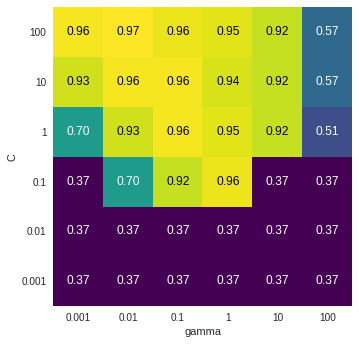

In [0]:
# Comparison of each gamma and each C value

# C is the strength of regularization
# a higher C value corresponds to less regularization
# when you use a high value for C logistic regression tries to fit the training set as best as possible
# while low values of C put more emphasis on fiding a coefficient that is closest to zero
# high C == more overfitting - tries that each data point individually be classified correctly
# low C == more generalization - will cause the algorithim to adjust to majority of data point
scores = np.array(results.mean_test_score).reshape(6, 6)
mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=param_grid['gamma'],
                    ylabel='C', yticklabels=param_grid['C'], cmap='viridis')

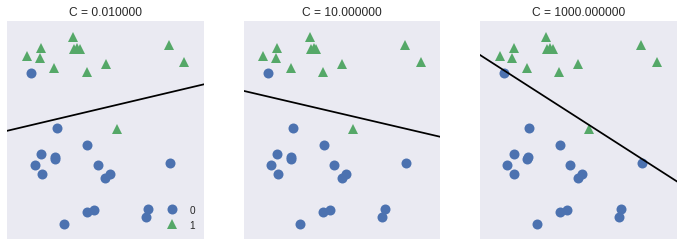

In [0]:
# example --> LogisticRegression(C=10)

mglearn.plots.plot_linear_svc_regularization()